# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

In [1]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader,Dataset
import transformers
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer, InputExample, losses, SentencesDataset
import faiss

import colbert

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Indexer, Searcher


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random


In [2]:
import os
os.chdir('Automated-Fact-checking-System')
print("Working space:", os.getcwd())


Working space: /home/lhg45/ColBERT/Automated-Fact-checking-System


# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [3]:
class ClaimEvidenceDataset(Dataset):

    def __init__(self, claims, evidence, tokenizer, max_len=512, if_train=True):
        self.claim_texts = []
        self.evidence_texts = []
        self.tokenizer = tokenizer
        self.max_length = max_len
        self.if_train = if_train
        self.claim_ids = []
        if if_train:
            self.labels = []

        self.label2id = {
            "SUPPORTS": 0,
            "REFUTES": 1,
            "NOT_ENOUGH_INFO": 2,
            "DISPUTED": 3
        }

        for claim_idx, claim_info in claims.items():
            self.claim_ids.append(claim_idx)
            self.claim_texts.append(claim_info['claim_text'])
            evidence_text = ""
            for evid in claim_info['evidences']:
                if evid in evidence:
                    evidence_text += evidence[evid] + " "
            self.evidence_texts.append(evidence_text.strip())
            if if_train:
                self.labels.append(self.label2id[claim_info['claim_label']])

            
    def __len__(self):
        return len(self.claim_texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.claim_texts[idx],
            self.evidence_texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        if self.if_train:
            return {
                'input_ids': encoded['input_ids'].squeeze(0),
                'attention_mask': encoded['attention_mask'].squeeze(0),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long),
                'claim_id': self.claim_ids[idx]
            }
        else:
            return {
                'input_ids': encoded['input_ids'].squeeze(0),
                'attention_mask': encoded['attention_mask'].squeeze(0),
                'claim_id': self.claim_ids[idx]
            }


In [4]:
with open("data/train-claims.json", 'r') as f:
    train_claims = json.load(f)

with open("data/test-claims-unlabelled.json", 'r') as f:
    test_claims = json.load(f)

with open("data/evidence.json", 'r') as f:
    evidence = json.load(f)

evidence_ids = list(evidence.keys())
evidence_texts = list(evidence.values())

with open("data/dev-claims-baseline.json", "r") as f:
    dev_data_baseline = json.load(f)

with open("data/dev-claims.json", "r") as f:
    dev_data = json.load(f)

'''
with open('data/evidence_colbert.tsv', 'w', encoding='utf-8') as f_out:
    for idx, text in enumerate(evidence.values()):
        text = text.replace("\t", " ")
        f_out.write(f"{idx}\t{text.strip()}\n")
'''


'\nwith open(\'data/evidence_colbert.tsv\', \'w\', encoding=\'utf-8\') as f_out:\n    for idx, text in enumerate(evidence.values()):\n        text = text.replace("\t", " ")\n        f_out.write(f"{idx}\t{text.strip()}\n")\n'

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
#This method has been deprecated, do not use it
#!!!*****only run once(I have run it in local), if you want to re-index, set overwrite=True*****!!!

#Colbert Indexing, Tokenization and embedding in evidence_colbert.txt
'''
checkpoint = "colbert-ir/colbertv2.0"
index_name = "evidence_index"
doc_maxlen = 180

with Run().context(RunConfig(nranks=1, experiment="colab_run", root="./colbert")):
    config = ColBERTConfig(nbits=2, root="./colbert")
    indexer = Indexer(checkpoint=checkpoint, config=config)
    #indexer.index(name=index_name, collection="data/evidence_colbert.tsv",overwrite=True)
    indexer.index(name=index_name, collection="data/evidence_colbert.tsv")
'''

In [5]:
#!!!Only run once, otherwise you want to refune-tune the model!!!
#Finetuning the intfloat/e5-base-v2 model base on our training data
train_pairs = []

for claim_info in train_claims.values():
    claim_text = claim_info["claim_text"]
    for evid_id in claim_info["evidences"]:
        if evid_id in evidence:
            evidence_text = evidence[evid_id]
            train_pairs.append((claim_text, evidence_text))

train_examples = [
    InputExample(texts=["query: " + claim, "passage: " + evidence]) for claim, evidence in train_pairs
]

e5_base_model = SentenceTransformer("intfloat/e5-base-v2") 

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
train_loss = losses.MultipleNegativesRankingLoss(e5_base_model)

e5_base_model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=0,
    warmup_steps=100,
    show_progress_bar=True,
    output_path="e5_finetuned_co2"
)

torch.cuda.empty_cache()

#model will be saved in the e5_finetuned_co2 folder in current working directory

Step,Training Loss


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [5]:
#!!!Only run once, otherwise you want to refune-tune the model!!!
#Finetuning the intfloat/e5-base-v2 model base on our training data， this will randomly sample 3 negative samples
train_examples = []

for claim_info in train_claims.values():
    claim_text = "query: " + claim_info["claim_text"]
    pos_ids = [eid for eid in claim_info["evidences"] if eid in evidence]
    if not pos_ids:
        continue

    pos_text = "passage: " + evidence[random.choice(pos_ids)]

    all_ids = set(evidence.keys())
    neg_pool = list(all_ids - set(pos_ids))
    if len(neg_pool) < 3:
        continue

    neg_ids = random.sample(neg_pool, k=3)
    neg_texts = ["passage: " + evidence[eid] for eid in neg_ids]

    for neg_text in neg_texts:
        train_examples.append(
            InputExample(texts=[claim_text, pos_text, neg_text])
        )

model = SentenceTransformer("intfloat/e5-base-v2")
print("Load model from e5_base_v2")

train_dataset = SentencesDataset(train_examples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)

train_loss = losses.TripletLoss(model=model)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=5,
    warmup_steps=100,
    show_progress_bar=True,
    output_path="e5_finetuned_co2_triplet",
)

torch.cuda.empty_cache()
#model will be saved in the e5_finetuned_co2_triplet folder in current working directory

Load model from e5_base_v2


Step,Training Loss
500,3.491500
1000,3.178300
1500,3.138300
2000,3.123200


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
'''
#!!!Only run once, otherwise you want to refune-tune the model!!!
#Finetuning the intfloat/e5-base-v2 model base on our training data, we used enforce-learning

def pos_neg_e5_enforce_training():

hard_negative_dict = {}

train_examples = []

for claim_id, claim_info in train_claims.items():
    query_text = "query: " + claim_info["claim_text"]
    pos_evidences = [evidence[eid] for eid in claim_info["evidences"] if eid in evidence]

    hard_negs = hard_negative_dict.get(claim_id, [])

    for pos_text in pos_evidences:
        if len(hard_negs) > 0:
            for neg_text in hard_negs:
                train_examples.append(
                    InputExample(texts=[query_text, "passage: " + pos_text, "passage: " + neg_text])
                )
        else:
            train_examples.append(
                InputExample(texts=[query_text, "passage: " + pos_text])
            )

e5_base_model = SentenceTransformer("intfloat/e5-base-v2")

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

if any(len(ex.texts) == 3 for ex in train_examples):
    train_loss = losses.SoftmaxLoss(
        model=e5_base_model,
        sentence_embedding_dimension=e5_base_model.get_sentence_embedding_dimension(),
        num_labels=2 
    )
else:
    train_loss = losses.MultipleNegativesRankingLoss(e5_base_model)

e5_base_model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=0,
    warmup_steps=100,
    show_progress_bar=True,
    output_path="e5_finetuned_co2_with_hardneg"
)



#model will be saved in the e5_finetuned_co2 folder in current working directory
'''

In [6]:
#Load the fine-tuned model
E5_model = SentenceTransformer("e5_finetuned_co2")


# Create Indexing system for evidence texts(only run once)
evidence_texts_with_prefix = ["passage: " + text for text in evidence_texts]

evidence_embeddings = E5_model.encode(evidence_texts_with_prefix, convert_to_tensor=False, show_progress_bar=True)

embedding_dim = evidence_embeddings[0].shape[0]
index = faiss.IndexFlatL2(embedding_dim)

index.add(np.array(evidence_embeddings))

faiss.write_index(index, "E5/e5_index.faiss")
torch.cuda.empty_cache()

# Load the index
e5_index = faiss.read_index("E5/e5_index.faiss")

Batches:   0%|          | 0/37776 [00:00<?, ?it/s]

In [7]:
#Roberta Model setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4).to(device)
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-large', num_labels=4).to(device)

epochs = 24

batch_size = 16

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler()#accelerate

train_steps = int((len(train_claims) * epochs)/batch_size)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

train_dataset = ClaimEvidenceDataset(train_claims, evidence, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

#valid_dataset = ClaimEvidenceDataset(test_claims, evidence, tokenizer, if_train = False)
#valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=True)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
#freeze last 3 layer
for param in model.parameters():
    param.requires_grad = False

for layer in model.roberta.encoder.layer[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True


In [10]:
def training(train_dataloader, model, optimizer, scheduler, scaler, device):
    model.train()
    correct_predictions = 0
    total_loss = 0
    num_batches = 0
    total_samples = 0

    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        num_batches += 1

    avg_epoch_loss = total_loss / num_batches
    accuracy = correct_predictions / total_samples


    return avg_epoch_loss, accuracy


def validating(val_dataloader, model, device):
    model.eval()
    all_predictions = []
    claim_ids = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)

            outputs = model(ids, attention_mask=mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            all_predictions.extend(preds.cpu().tolist())
            claim_ids.extend(batch["claim_id"])

    return claim_ids, all_predictions
    


Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.77it/s]


Train Loss: 1.3618
Train Accuracy: 0.3168
Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.81it/s]


Train Loss: 1.1632
Train Accuracy: 0.5171
Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.82it/s]


Train Loss: 0.9919
Train Accuracy: 0.6262
Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:25<00:00,  3.03it/s]


Train Loss: 0.9637
Train Accuracy: 0.6221
Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.76it/s]


Train Loss: 0.8529
Train Accuracy: 0.6604
Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.82it/s]


Train Loss: 0.7979
Train Accuracy: 0.6849
Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.81it/s]


Train Loss: 0.7574
Train Accuracy: 0.7020
Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.80it/s]


Train Loss: 0.6954
Train Accuracy: 0.7215
Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:25<00:00,  2.99it/s]


Train Loss: 0.6568
Train Accuracy: 0.7280
Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.81it/s]


Train Loss: 0.6197
Train Accuracy: 0.7419
Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.81it/s]


Train Loss: 0.5415
Train Accuracy: 0.7850
Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.81it/s]


Train Loss: 0.4751
Train Accuracy: 0.8103
Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:25<00:00,  2.99it/s]


Train Loss: 0.4115
Train Accuracy: 0.8502
Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.82it/s]


Train Loss: 0.3672
Train Accuracy: 0.8632
Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.80it/s]


Train Loss: 0.3372
Train Accuracy: 0.8730
Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:25<00:00,  2.99it/s]


Train Loss: 0.2720
Train Accuracy: 0.9015
Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:29<00:00,  2.64it/s]


Train Loss: 0.2343
Train Accuracy: 0.9194
Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:25<00:00,  2.98it/s]


Train Loss: 0.2212
Train Accuracy: 0.9275
Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.82it/s]


Train Loss: 0.1975
Train Accuracy: 0.9357
Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.83it/s]


Train Loss: 0.1715
Train Accuracy: 0.9511
Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.79it/s]


Train Loss: 0.1362
Train Accuracy: 0.9642
Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.83it/s]


Train Loss: 0.1468
Train Accuracy: 0.9568
Epoch 23/24
----------


 70%|██████████████████████████████████████████████████▍                     | 54/77 [00:18<00:07,  3.00it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:25<00:00,  2.99it/s]


Train Loss: 0.1337
Train Accuracy: 0.9634
Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.82it/s]


Train Loss: 0.1100
Train Accuracy: 0.9642


/tmp/ipykernel_7218/736255512.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epoch_list, train_losses_list, 'bo-', label="Training Loss", color='blue')


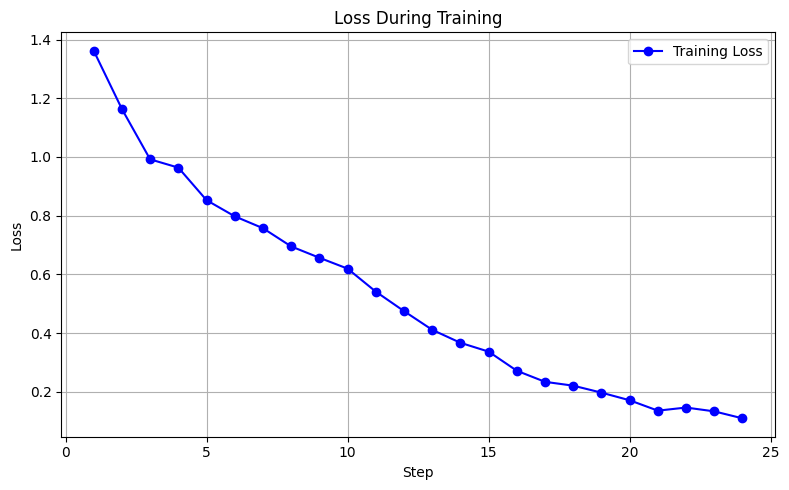

/tmp/ipykernel_7218/736255512.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epoch_list, train_accuracies, 'bo-', label='Training Accuracy', color='green')


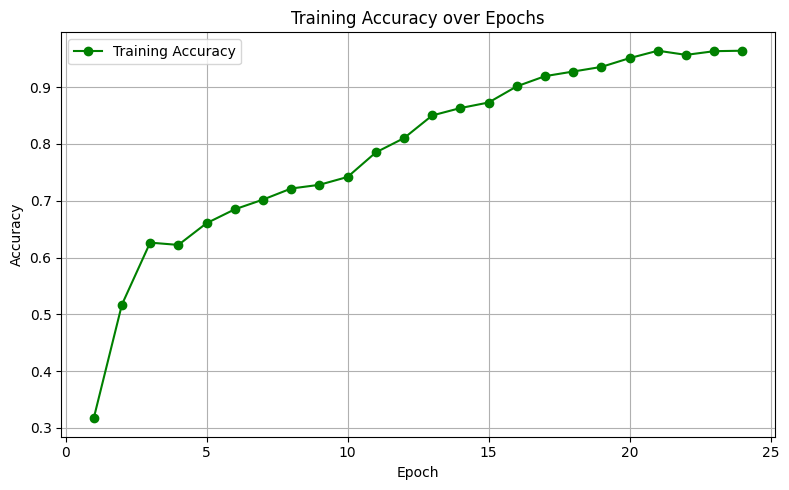

Final model saved to model_checkpoints/roberta_final.pt


In [10]:
#Training
train_losses_list = []
train_accuracies = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_loss, accuracy = training(train_dataloader, model, optimizer, scheduler, scaler, device)
    print(f'Train Loss: {train_loss:.4f}'),
    print(f'Train Accuracy: {accuracy:.4f}')

    train_losses_list.append(train_loss)
    train_accuracies.append(accuracy)

epoch_list = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epoch_list, train_losses_list, 'bo-', label="Training Loss", color='blue')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epoch_list, train_accuracies, 'bo-', label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Save the final model
save_path = "model_checkpoints/roberta_final.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': epochs,
    'loss': train_loss
}, save_path)

print(f"Final model saved to {save_path}")
torch.cuda.empty_cache()


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
#(!!!Deprecated!!!)Colbert Retrieval
checkpoint = "colbert-ir/colbertv2.0"
index_name = "evidence_index"
doc_maxlen = 180
searcher = Searcher(index=index_name, checkpoint=checkpoint, index_root="colbert/colab_run/indexes")

def retrieve(claim, k=10, threshould=2.0):
    with torch.no_grad():
        doc_ids, rank, scores = searcher.search(claim, k=k)

        print("scores: " , scores)
        Top_score = scores[0]
        print(doc_ids)

        filtered = [
            (doc_id, score)
            for doc_id, score in zip(doc_ids, scores)
            if score >= Top_score - threshould
        ]

        if not filtered:
            return ""
        
        retrieved_text = " ".join([
            searcher.collection[doc_id].replace("\n", " ").strip()
            for doc_id, score in filtered
        ])
        return retrieved_text

claim = "Weather Channel co-founder John Coleman provided evidence that convincingly refutes the concept of anthropogenic global warming."
retrieved_evidence = retrieve(claim)

print(retrieved_evidence)

In [ ]:
#E5 Retrieval， we used L2 distance and returned the similar evidences to the top one(based on epsilon).
def E5_retrieve(claim, E5_model, index, epsilon=0.1, top_k=10, use_inner_product=True):
    result = {}

    for claim_id, info in claim.items():
        claim_text = info["claim_text"]
        claim_emb = E5_model.encode(f"query: {claim_text}")

        D, I = index.search(np.array([claim_emb]), k=top_k)

        scores = D[0]
        if not use_inner_product:
            scores = -scores

        indices = I[0]

        best_score = max(scores)
        relative_threshold = best_score - epsilon

        passed = [(i, s) for i, s in zip(indices, scores) if s >= relative_threshold]

        top_evid_ids = [evidence_ids[i] for i, _ in passed]

        result[claim_id] = {
            "claim_text": claim_text,
            "evidences": top_evid_ids,
        }

    return result

'''
claim = {"claim-2967": {"claim_text": "Tree-ring proxy reconstructions are reliable before 1960, tracking closely with the instrumental record and other independent proxies."}}
claim_e5 = E5_retrieve(claim, E5_model,e5_index)
print(claim_e5)
'''


'\nclaim = {"claim-2967": {"claim_text": "Tree-ring proxy reconstructions are reliable before 1960, tracking closely with the instrumental record and other independent proxies."}}\nclaim_e5 = E5_retrieve(claim, E5_model,e5_index)\nprint(claim_e5)\n'

In [17]:
e5_index = faiss.read_index("E5/e5_index.faiss")
E5_model = SentenceTransformer("e5_finetuned_co2")
checkpoint = torch.load("model_checkpoints/roberta_final.pt", map_location='cuda') 
model.load_state_dict(checkpoint['model_state_dict'])

print("Model loaded successfully")

model.eval()

batch_size = 16

val_data = E5_retrieve(dev_data, E5_model,e5_index)
print("retrieved evidences finished")

valid_dataset = ClaimEvidenceDataset(val_data, evidence, tokenizer, if_train = False)
valid_dataloader = DataLoader(valid_dataset, batch_size)

id2label = {
    0: "SUPPORTS",
    1: "REFUTES",
    2: "NOT_ENOUGH_INFO",
    3: "DISPUTED"
}

claim_ids, predictions = validating(valid_dataloader, model, 'cuda')
print("validating finished")

label_names = [id2label[p] for p in predictions]

for cid, label in zip(claim_ids, label_names):
    val_data[cid]["claim_label"] = label

with open("data/dev-claims-test.json", "w") as f:
    json.dump(val_data, f)



Model loaded successfully
retrieved evidences finished


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.37s/it]

validating finished


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*